In [67]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

In [7]:
f = open("Experiments/deepfool_car_distance_metrics.txt", 'w')

In [4]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("car", lambda: lru_cache()(car)())
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
         #bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]
        #("random", partial(random_batch, n_instances=10)),
        #("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False), n_instances=10, log_metrics=f)),
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 1
    }
}

In [5]:
results = librun.run(matrix, force_run=True)

PicklingError: Could not pickle the task to send it to the workers.

In [10]:
tabulate(metrics, headers=["Min", "Mean", "Max"], tablefmt="fancy")

'Min    Mean    Max\n-----  ------  -----'

In [11]:
metrics

[]

## Manual

In [18]:
X, y = car()

X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)

clf = svm.SVC(kernel='linear', probability=True)

clf.fit(X_labelled, y_labelled)

SVC(kernel='linear', probability=True)

In [19]:
Attack = DeepFool

In [23]:
classifier = ScikitlearnSVC(
    model=clf
)

attack = Attack(classifier)

adversarial_examples = attack.generate(X_unlabelled)

dists = paired_distances(X_unlabelled, adversarial_examples, metric="euclidean")

In [24]:
dists.min(), dists.mean(), dists.max()

(0.0017191008177918398, 0.8544173149842315, 3.276952759666242)

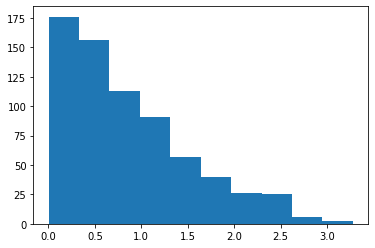

In [26]:
plt.hist(dists);

In [61]:
Attack=partial(FastGradientMethod, minimal=True, eps=1e-2, eps_step=1e-4)

In [62]:
classifier = ScikitlearnSVC(
    model=clf
)

attack = Attack(classifier)

adversarial_examples = attack.generate(X_unlabelled)

dists = paired_distances(X_unlabelled, adversarial_examples, metric="euclidean")

In [63]:
dists.min(), dists.mean(), dists.max()

(0.0, 2.549772781239032, 2.6457513110645907)

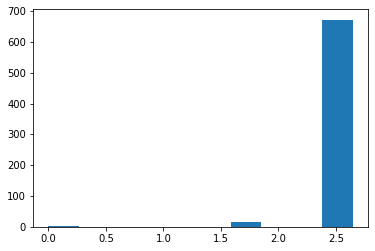

In [64]:
plt.hist(dists);

In [73]:
def func(x):
    eps, eps_step = x
    Attack = partial(FastGradientMethod, minimal=True, eps=eps, eps_step=eps_step)
    
    classifier = ScikitlearnSVC(
        model=clf
    )

    attack = Attack(classifier)

    adversarial_examples = attack.generate(X_unlabelled)

    dists = paired_distances(X_unlabelled, adversarial_examples, metric="euclidean")
    
    idx = np.argsort(dists)
    
    new_clf = svm.SVC(kernel='linear')
    new_clf.fit(np.concatenate((X_labelled, X_unlabelled[idx[:10]])), np.concatenate((y_labelled, y_oracle[idx[:10]])))
    
    return -new_clf.score(X_test, y_test)

In [ ]:
scipy.optimize.basinhopping(func, [0.3, 0.1], niter=100, minimizer_kwargs={"method": "L-BFGS-B", "bounds": [(1e-99, 100), (1e-99, 100)]}, disp=True)